# Text Prediction and Generation using LSTM Networks

_______________
## Google drive code only
Only run the following sections in a colaboratory shell

In [ ]:
%%time
# Code to read google drive files into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%%time
def importFile(fileName: str, fileID: str):
  '''Imports a file into the Colaboratory workspace. The fileID can be 
     found in the file's Share Link'''
  print("Grabbing file " + str(fileName) + " with id = " + str(fileID)) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':fileID}) 
  downloaded.GetContentFile(fileName) 

In [ ]:
# Import all the datasets we are going to use for our project
importFile('TheLordOfTheRings_Book1.txt', '1crAeSigOaQcT62W7EjcwrKcIVBx5ayeh')

In [ ]:
importFile('GoogleNews-vectors-negative300.bin', '1zzUeVFsRYw3lWe6kjk1nccywCkMDp-AY')

## End of Google drive code
_________________________________________

## Setup Word Embeddings

- Load top 1 million (out of 3 million) word embeddings from the binary file.
- The vectors are 300 dimensions large and are created using the word2vec algorithm.
- The model was trained on the GoogleNews corpus and the vector is taken from a latent layer, representing a compressed representation of a word with its surrounding context.  
    - The GoogleNews corpus is a similar size to the English version of Wikipedia.
- We cannot load all 3,000,000 vectors or else we will run out of RAM.
    - Missing words will be added programmatically

In [1]:
%%time
import gensim
import numpy as np

# This line imports 100,000 vectors
embeddings = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', limit=100000, binary=True)

Wall time: 4.81 s


### Word Embedding Examples

When we import the binary file using the gensim library, we can easily explore interesting properties of word embeddings. Much like a latent vector produced using an autoencoder, each embedding holds meaningful information about each word and the context in which it is used. The following examples explore the latent space in which these vectors reside.

In [2]:
# Vector addition/subtraction examples:
# What are the top three vectors similar to boy and girl?
print(embeddings.most_similar(positive=["boy", "girl"], topn=3))
# What is a fish without water?
print(embeddings.most_similar(positive=["fish"], negative=["water"], topn=3)) 

# Can also obtain nearby vectors. Here of an example where we slightly modify 
# the "woman" vectors and test if we can get back the same bector using the most_similar function
v = np.copy(embeddings["woman"])
v[0] += 0.2
print(embeddings.most_similar(positive=[v], topn=1))

[('teenage_girl', 0.7674504518508911), ('teenager', 0.7674364447593689), ('toddler', 0.701943576335907)]
[('striped_bass', 0.47242963314056396), ('halibut', 0.43524497747421265), ('rockfish', 0.4258560836315155)]
[('woman', 0.9972377419471741)]


![](https://drive.google.com/uc?export=view&id=1e9PxMNKjTXDx7KZDxHpC4ENmz0sXHl_g)

Figure 1: Word embeddings organize terms based on the context in which they are used. All three example images demonstrate possible transformation functions that convey structure in the latent space. In the "Male-Female" image, there exists a function that relates male-oriented words to their corresponding female-oriented words. In the "Verb Tense" image, there exists a function that maps a present-tense word to its past-tense conjugation. In the "Country-Capital" image, there exists a function that relates a country to its corresponding capital city.

_________________________________________

## Preprocessing

1. Split training data into individual tokens, ie: "Here is a sentence" --> \["Here" "is" "a" "sentence"\]
2. Use nltk to split training data into ngram phrases to feed into our LSTM network
    - The model's architecture will automatically adjust based on ngram size
3. Shuffle the data
4. Split the data into training and validation

In [3]:
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


def tokenizeFile(fileName: str) -> list:
    '''Will take in the name of a txt file located in the base directory 
    of the drive and return a list of tokens. Tokens are defined to be
    any nonzero sequence of characters.'''
    tokens = []
    with open(fileName, 'r', encoding="ISO-8859-1") as file:
        tokens = word_tokenize(file.read())
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Used to generate new embeddings with random weights
seed = 0
# Used to store only the word vectors we come across in a file
my_embeddings = gensim.models.keyedvectors.WordEmbeddingsKeyedVectors(300)


def addNewEmbedding(token: str):
    '''Adds a new word embedding to our vector set with randomly initialized values.
    Returns the newly created embedding.'''
    global seed
    np.random.seed(seed)
    seed += 1
    weights = np.random.uniform(-1,1,300)
    my_embeddings.add(token, weights)
    return my_embeddings[token]


def flipFirstChar(word: str) -> str:
    '''Capitalizes/Un-capitalizes the first character of the word.
    It is not garunteed that all terms in the WordNet corpus are lower
    case or upper case. So if we can't find a term then it is a good 
    idea to fip the first character's case and try again. '''
    if word[0].isupper():
        return word[0].lower() + word[1:]
    else:
        return word[0].upper() + word[1:]


def tokensToVectors(tokens: list) -> (list, list):
    '''Convert a list of terms into a list of word embeddings. 
    If an embeddding exists for a term, we add it to our vector set.
    If an embedding does not exist for a term, we create a new embedding and add it to our vector set.'''
    vectors = []
    unknownTokens = set()
    for token in tokens:
        # The vector exists in the GoogleNews vector set
        if token in embeddings:
            weights = embeddings[token]
            vectors.append(weights)
            my_embeddings.add(token, weights)
        # The flipFirstChar'ed vector exists in the GoogleNews vector set
        elif flipFirstChar(token) in embeddings:
            weights = embeddings[flipFirstChar(token)]
            vectors.append(weights)
            my_embeddings.add(token, weights)
        # The vector does not exist so make a new vector
        else:
            weights = addNewEmbedding(token)
            vectors.append(weights)
            unknownTokens.add(token)
    return vectors, unknownTokens


def phrasesToVectors(ngramList: list, summary=True) -> (list, list):
    '''Calls wordsToVectors() on a list of lists. This function will be called
       after data is split into ngrams. Each phrase in the code below operations
       on a single ngram.'''
    ngramVectorList = []
    allUnknownTokens = set()
    for tokens in ngramList:
        vectors, unknownTokens = tokensToVectors(tokens)
        ngramVectorList.append(vectors)
        allUnknownTokens = allUnknownTokens.union(unknownTokens)  
    if summary:
        print("Number of training ngrams: " + str(len(ngramVectorList)))
        print("Number of unknown vector terms created: " + str(len(allUnknownTokens)))
    print("Shape of training set: " + str(np.shape(ngramVectorList)))
    return np.array(ngramVectorList, dtype=np.ndarray), allUnknownTokens

In [5]:
%%time
from nltk import ngrams

# Cut number of words so we can fit everything in memory
words_all = tokenizeFile("TheLordOfTheRings_Book1.txt")
words = words_all[:len(words_all)//50]
print("Using " + str(len(words)) + " non-unique words from the text")
# Change this parameter to decrease or increase the size of the training samples
N = 5
ngrams_words = ngrams(words, N + 1)
ngram_vectors_original, _ = phrasesToVectors(ngrams_words)

Using 4435 non-unique words from the text
Number of training ngrams: 4430
Number of unknown vector terms created: 149
Shape of training set: (4430, 6, 300)
Wall time: 20.1 s


In [6]:
%%time
# Make a copy of the original ngrams just in case we want to run our model with different parameters
ngram_vectors = ngram_vectors_original
# Shuffling the data to increase validation accuracy
np.random.shuffle(ngram_vectors)
print("Samples Shape: " + str(ngram_vectors.shape))

Samples Shape: (4430, 6, 300)
Wall time: 56.8 ms


### Training/Validation Split
First we will set aside 10% of our data for validation. 

Each phrase (element) in ngram_vectors will be split into two parts. All the terms preceeding the last term will be used to predict the last term. So, if we have an array of phrases of size six, then these phrases will be split into two arrays of equal size. For example: 

phrase: \[This tale grew in the telling\]
 - input data = \[This tale grew in the\]
 - expected output = \[tale grew in the telling\]

In [7]:
import math

# Split data into training and validation
split = math.floor(np.size(ngram_vectors, axis=0) * 0.9)
training = ngram_vectors[:split,:,:]
validation = ngram_vectors[split:,:,:]

# Split the training and validation data as discussed above ^
train_input = training[:,:-1,:]
# train_predict = np.expand_dims(training[:,-1,:], axis=1)
train_predict = training[:,1:,:]


validation_input = validation[:,:-1,:]
# validation_predict = np.expand_dims(validation[:,-1,:], axis=1)
validation_predict = validation[:,1:,:]

print("Training Input: " + str(train_input.shape) + ", Training Predict: " + str(train_predict.shape))
print("Validation Input: " + str(validation_input.shape) + ", Validation Predict: " + str(validation_predict.shape))

Training Input: (3987, 5, 300), Training Predict: (3987, 5, 300)
Validation Input: (443, 5, 300), Validation Predict: (443, 5, 300)


## Architecture Explaination

- The input shape is 300 because we take in each dimension of the word embedding as input.
- The default Tanh activation function is used on LSTM cells.
- No dropout layers are used because they decrease training accuracy with negligible improvements to validation accuracy.
- Tanh activation function is used on the final dense layer to restrict the output of the vector from -1 to 1 because word embeddings are normalized betweeen -1 and 1.
- A third LSTM layer increases training and validation accuracy
- Loss is cosine similarity because word2vec also uses cosine similarity to measure the distance between word vectors.

This table represents our adjustments to the model with its corresponding testing and validation scores. All results use 100 epochs, a batch size of 32, and a cosine proximity loss function.

| Description | Training Accuracy | Validation Accuracy | |
|------|------|------|-|
| 2 LSTM with sigmoid<br>1 Dense with no activation | 0.4603 | 0.3670 ||
| 2 LSTM with tanh<br>2 Dropout<br>1 Dense with no activation | 0.4067 | 0.3761 ||
| 2 LSTM with tanh<br>2 Dropout<br>1 Dense with tanh | 0.4219 | 0.3946 ||
| 2 LSTM with tanh<br>1 Dense with no activation | 0.4978 | 0.3707 ||
| 2 LSTM with tanh<br>1 Dense with tanh | 0.5012 | 0.3887 ||
| 3 LSTM with tanh<br>1 Dense with tanh | 0.5548 | 0.4068 |Best Model|


In [22]:
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

input_shape=(N, 300)
print("Input Shape: " + str(input_shape))

model = Sequential()  
model.add(LSTM(300, input_shape=input_shape, return_sequences=True, activation='tanh'))
model.add(LSTM(300, return_sequences=True, activation='tanh'))
model.add(LSTM(300, return_sequences=True, activation='tanh'))
model.add(Dense(300, activation='tanh'))

model.compile(loss='cosine_proximity', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Input Shape: (5, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 300)            721200    
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 300)            721200    
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 300)            721200    
_________________________________________________________________
dense_6 (Dense)              (None, 5, 300)            90300     
Total params: 2,253,900
Trainable params: 2,253,900
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
%%time
history = model.fit(train_input, train_predict, epochs=100, batch_size=32, verbose=2, validation_data=(validation_input, validation_predict))

Train on 3987 samples, validate on 443 samples
Epoch 1/100
 - 6s - loss: -3.5597e-01 - acc: 0.0447 - val_loss: -3.8157e-01 - val_acc: 0.0447
Epoch 2/100
 - 4s - loss: -3.9825e-01 - acc: 0.0621 - val_loss: -4.1936e-01 - val_acc: 0.0659
Epoch 3/100
 - 4s - loss: -4.3657e-01 - acc: 0.0907 - val_loss: -4.4560e-01 - val_acc: 0.0930
Epoch 4/100
 - 4s - loss: -4.6695e-01 - acc: 0.1099 - val_loss: -4.6585e-01 - val_acc: 0.1043
Epoch 5/100
 - 4s - loss: -4.9496e-01 - acc: 0.1269 - val_loss: -4.8623e-01 - val_acc: 0.1237
Epoch 6/100
 - 4s - loss: -5.2241e-01 - acc: 0.1454 - val_loss: -5.0614e-01 - val_acc: 0.1359
Epoch 7/100
 - 4s - loss: -5.4939e-01 - acc: 0.1626 - val_loss: -5.2412e-01 - val_acc: 0.1463
Epoch 8/100
 - 4s - loss: -5.7553e-01 - acc: 0.1819 - val_loss: -5.4362e-01 - val_acc: 0.1670
Epoch 9/100
 - 4s - loss: -6.0048e-01 - acc: 0.2043 - val_loss: -5.6233e-01 - val_acc: 0.1675
Epoch 10/100
 - 4s - loss: -6.2429e-01 - acc: 0.2172 - val_loss: -5.8075e-01 - val_acc: 0.1828
Epoch 11/100

Epoch 87/100
 - 4s - loss: -8.6735e-01 - acc: 0.5423 - val_loss: -7.6035e-01 - val_acc: 0.4059
Epoch 88/100
 - 4s - loss: -8.6788e-01 - acc: 0.5396 - val_loss: -7.6089e-01 - val_acc: 0.4072
Epoch 89/100
 - 4s - loss: -8.6805e-01 - acc: 0.5426 - val_loss: -7.5980e-01 - val_acc: 0.4005
Epoch 90/100
 - 4s - loss: -8.6841e-01 - acc: 0.5442 - val_loss: -7.6078e-01 - val_acc: 0.4059
Epoch 91/100
 - 4s - loss: -8.6857e-01 - acc: 0.5460 - val_loss: -7.6152e-01 - val_acc: 0.3914
Epoch 92/100
 - 4s - loss: -8.6891e-01 - acc: 0.5452 - val_loss: -7.6084e-01 - val_acc: 0.3959
Epoch 93/100
 - 4s - loss: -8.6914e-01 - acc: 0.5479 - val_loss: -7.6118e-01 - val_acc: 0.3973
Epoch 94/100
 - 4s - loss: -8.6936e-01 - acc: 0.5520 - val_loss: -7.6104e-01 - val_acc: 0.4090
Epoch 95/100
 - 4s - loss: -8.6958e-01 - acc: 0.5482 - val_loss: -7.6176e-01 - val_acc: 0.4014
Epoch 96/100
 - 4s - loss: -8.6982e-01 - acc: 0.5538 - val_loss: -7.6159e-01 - val_acc: 0.3977
Epoch 97/100
 - 4s - loss: -8.7015e-01 - acc: 0.54

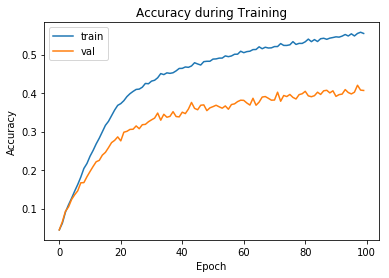

In [24]:
from matplotlib import pyplot as plt

def plot_accuracy(history):
  plt.plot(history.history['acc'],label='train')
  if 'val_acc' in history.history:
    plt.plot(history.history['val_acc'],label='val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Accuracy during Training')
  plt.show()

plot_accuracy(history)

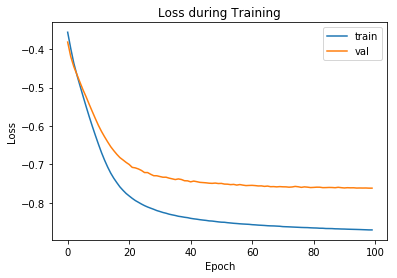

In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'],label='train')
  if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'],label='val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss during Training')
  plt.show()

plot_loss(history)

## Text Prediction

Here we demonstrate the predictive nature of our model. In order to make a prediction, our model must be provided a seed. The seed must be equal to N (defined above as the input size to our model). In the example shown below, we seed our model with the first phrase of the book "This tale grew in the" and we expect each prediction to be the next word in the phrase, such as "tale grew in the telling." The correct pairings are as follows:

This => tale

tale => grew

grew => in

in => the

the => telling

In [38]:
def getTestingPhrase(sentence: str):
    '''Converts a phrase with N tokens into a list of vectors'''
    if len(sentence.split()) != N:
        print("Sentence must contain exactly " + str(N) + " words.")
        return None
    return np.array([my_embeddings[i] for i in sentence.split()])


def printPredictions(predictions, testingPhrase):
    '''Runs the vectorized phrase on the model and compares the predicted output to the ground truth'''
    num_outputs = predictions.shape[1]
    for i in range(num_outputs):
        print(testingPhrase.split()[i] + " => ", end='')
        print(my_embeddings.most_similar(positive=[predictions[0][i]], topn=1))


def predictNext(testingPhrase: str):
    test_input = getTestingPhrase(testingPhrase)
    test_input = np.expand_dims(test_input, axis=0)
    predictions = model.predict(test_input)
    printPredictions(predictions, testingPhrase)

    
# Use the first sentence of the text to test how well the model can recall the next word from the text
    
# This tale grew in the telling until it became a history of the Great War of the Ring 
# and included many glimpses of the yet more ancient history that preceded it.
predictNext("This tale grew in the")
predictNext("telling until it became a")
# predictNext("history of the Great War")
# predictNext("of the Ring and included")
# predictNext("many glimpses of the yet")
# predictNext("more ancient history that preceded")

This => [('tale', 0.7269088625907898)]
tale => [('grew', 0.9325688481330872)]
grew => [('in', 0.9984217882156372)]
in => [('the', 0.9988089203834534)]
the => [('telling', 0.9366496801376343)]
telling => [(',', 0.9804345369338989)]
until => [('it', 0.8028238415718079)]
it => [('became', 0.7871156930923462)]
became => [('a', 0.9984987378120422)]
a => [('history', 0.9456530809402466)]


It appears that our model has done a good job memorizing sequences of text from the book. Our model starts off with lower accuracy because it is not provided with much context. But as the model predict subsequent terms, the accuracy increases. In this example, the model recalls 90% of the terms.

In [99]:
def getSamplesFromRange(low, high):
    print("["+str(low)+","+" "+str(high)+"]: ", end="")
    arr = []
    for _ in range(5):
        arr.append(np.random.uniform(low,high,300))
    arr = np.array([np.array(arr)])
    predictions = model.predict(arr)
    num_outputs = predictions.shape[1]
    outputs = set()
    nns = 3 # nearest neighbors
    for i in range(num_outputs):
        tuple_list = my_embeddings.most_similar(positive=[predictions[0][i]], topn=3)
        tokens = [i[0] for i in tuple_list]
        outputs = outputs | set(tokens)
    print(outputs)

getSamplesFromRange(-1, -0.5)
getSamplesFromRange(-0.5, 0)
getSamplesFromRange(0, 0.5)
getSamplesFromRange(0, 1)

[-1, -0.5]: {'tale', 'and', '.', 'woodlands', 'Of', 'chapter', 'And', '(', 'forest', 'Then', ','}
[-0.5, 0]: {'Prologue', '.', 'I', 'my', '(', 'remember', ','}
[0, 0.5]: {'in', 'so', 'even', 'the', 'where', 'then', 'but'}
[0, 1]: {'move', 'in', 'so', 'that', 'do', 'the', 'have', 'they', 'but', 'it', 'need'}


Here we experiment with the model's latent space by making the model predict specified ranges of vectors. From our experiments, the model has appeared to have clustered the input vectors based on their usage. Embeddings with values between [-1, 0] correspond to tokens that are used less often. Some examples that were generated in this range include: 

tale, '.', woodlands, chapter, '(', forest, ',', Prologue, remember

On the other hand, embeddings with values between [0, 1] correspond to tokens that are used more often, such as stop words. Some examples in this range include: 

in, so, even, the, where, then, but, move, in, so, that, do, have, they, it

In [100]:
# Example output when the model is ran with all zeros
arr = []
for _ in range(5):
    arr.append(np.random.uniform(low,high,300))
arr = np.array([np.array(arr)])
predictions = model.predict(arr)
num_outputs = predictions.shape[1]
for i in range(num_outputs):
    print(my_embeddings.most_similar(positive=[predictions[0][i]], topn=1)[0][0])

NameError: name 'low' is not defined

## Text Generation

Here we experiment with text generation. The goal of text generation is to provide the model with a seed phrase and have the model generate many values into the "future." We use an iterative algorithm to predict each word. 

Given a window size of $N$, to predict a word $w_i$, we input $[w_{i-N}, w_{i-N+1}, w_{i-N+2}, ..., w_{i-1}]$

Then, we slide our window on top of our newly generated term and repeat this generation step.

In [47]:
# generate text out of input sequence string.
# The seed input string has to contain at least N words.
# If it contains more than N words only the last N will be feed into the network

# get array of the last 5 words of the sentence
def getVariableTestingPhrase(sentence: str):
    '''Converts a variable length phrase with at least N tokens into a list of vectors'''
    if len(sentence.split()) < N:
        print("Sentence must contain at least " + str(N) + " words.")
        return None
    return np.array([my_embeddings[i] for i in sentence.split()][-N:])


def get_word_from_vector(array_seq):
    '''Given the output to our model, obtain the last vector in the array
    and fetch its corresponding text translation.'''
    return my_embeddings.most_similar(positive=[array_seq[0][-1]], topn=1)[0]


def generate_seq(model, seed_text, n_words):
    '''Given the model and the seed text, the function will generate n_words number of tokens and
    append these tokens to the end of the seed text'''
    text_seq = seed_text.split()
    # Input Data
    text_array_seq = getVariableTestingPhrase(seed_text)
    for i in range(n_words):
        input = np.expand_dims(text_array_seq, axis=0)
        pred = model.predict(input, verbose=0)
        pred_word = get_word_from_vector(pred)
        text_seq.append(pred_word[0])
        # Append predicted word to the end of text_array_seq
        # 1. Remove first
        text_array_seq = text_array_seq[1:,:]
        # 2. Append to last
        last_pred = pred[:,-1,:]
        text_array_seq = np.append(text_array_seq, last_pred, axis=0)
    return ' ' .join(text_seq)
  

seed_text = "Those who had asked for more information about"
generated_text = generate_seq(model, seed_text, 10)
print(generated_text)

seed_text = "Bilbo was very rich and"
generated_text = generate_seq(model, seed_text, 10)
print(generated_text)

Those who had asked for more information about hobbits the experience of the that the it it the
Bilbo was very rich and kindly or only but it us additional or or or


- Reasons for repeated words:
    - Mode collapse
    - Embeddings are not uniformly distributed in the latent space. If there are large empty spaces then there won't be a "nearest", or most similar vector.
- Is able to generate around 7 terms before it starts to repeat itself.